# Predict MPS values from simulation data

## import modules

In [80]:
from numpy import genfromtxt
import numpy as np
import math
from pylab import *
import urllib
import os
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.metrics import mean_squared_error
from __future__ import division
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lmfit import Model
import pickle
import seaborn as sns
from matplotlib.widgets import Slider
pl.style.use('seaborn')
pl.rc('font',family='Arial')

## enter value to predict, load model  
  
Options:  
"tan": phase lag (omega x tau)  
"tau": relaxation time in ns  
"third": third harmonic amplitude (normalized)  
"fifth": fifth harmonic amplitude (normalized)  
"ratio": ratio of 3rd to 5th harmonics  
  
Brownian relaxation options: "on" or "off"

In [100]:
predict_value = "tau"
brownian = "on"

if brownian == "on":
    if predict_value == "tan":
        sim_file = open('mpsmodel-tan.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "tau":
        sim_file = open('mpsmodel-tau.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "third":
        sim_file = open('mpsmodel-third.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "fifth":
        sim_file = open('mpsmodel-fifth.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "ratio":
        sim_file = open('mpsmodel-ratio.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
elif brownian == "off":
    if predict_value == "tan":
        sim_file = open('mpsmodel-tan-frozen.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "tau":
        sim_file = open('mpsmodel-tau-frozen.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "third":
        sim_file = open('mpsmodel-third-frozen.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "fifth":
        sim_file = open('mpsmodel-fifth-frozen.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()
    if predict_value == "ratio":
        sim_file = open('mpsmodel-ratio-frozen.pkl', 'rb')
        model = pickle.load(sim_file)
        sim_file.close()

## input parameters to predict
Required input variables: field (mT), frequency (Hz), size (nm), K (J/m^3), gyro
  
Data limits:  
field (mT): {10, 11, ... 49, 50}  
frequency (Hz): {1000, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 150000}  
size (nm): {13, 14, ... 34, 35}  
K (J/m^3): {1000, 2000, ... 19000, 20000}  
gyro: {1, 2, 4, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120} 


In [24]:
field = 20
frequency = 25000
size = 25.2
K = 4000
gyro = 1

## predict value

In [10]:
p = model.predict([[field, frequency, size, K, gyro]])
print("predicted "+predict_value+" = {}".format(p[0]))

predicted tan = 0.21448823618097496


# Plot predicted point  
Input changed parameter

In [11]:
changed_param = "size"

## import simulation data for plotting
Only do this once -- will take a long time

In [29]:
freqs = []
fields = []
s_size = []
third = []
fifth = []
b = []
s_K = []
phase1 = []
s_gyro = []

for f in os.listdir('fits'):
    if f[-1] == 'v':
        filename = 'fits/' + f
        filedata = np.genfromtxt(filename, delimiter=',')
        f = f[:-4]
        s = str.split(f,"_")
        s_size.append(float(s[0][:-2]))
        fields.append(float(s[1][:-2]))
        freqs.append(int(s[2][:-3])*1000)
        moment = filedata[:,1]
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        phase1.append(np.angle(np.fft.fft(moment)[1]))
        if s[-1] == "frozen":
            b.append("off")
        else:
            b.append("on")     
        g = 1.
        k = 5000.
        for ss in range(2,len(s)):
            if s[ss][0] == "g":
                g = float(s[ss][1:])
            if s[ss][0] == "K":
                k = 1000*float(s[ss][1:])
                if k > 25000:
                    k /= 1000.
        s_gyro.append(g)
        s_K.append(k)
            
sdata = pd.DataFrame({'frequency': freqs, 'field': fields,'size': s_size, \
                     'third': third, 'fifth': fifth, 'b': b, \
                     'K': s_K, 'phase1': phase1, 'gyro': s_gyro})

sdata['ratio'] = sdata['fifth']/sdata['third']
sdata['angF'] = 2*np.pi*sdata['frequency']
sdata['tan'] = abs(np.tan(sdata['phase1']))
sdata['tau'] = sdata['tan']/sdata['angF']

## take subset of data for plotting


In [30]:
sub = sdata

if changed_param == "field": param = field
else: sub = sub[(sub['field'] == field)]

if changed_param == "frequency": param = frequency
else: sub = sub[(sub['frequency'] == frequency)]

if changed_param == "size": param = size
else: sub = sub[(sub['size'] == size)]

if changed_param == "K": param = K
else: sub = sub[(sub['K'] == K)]
    
if changed_param == "gyro": param = gyro
else: sub = sub[(sub['gyro'] == gyro)]

sub = sub.sort_values(by=changed_param)

## generate plot

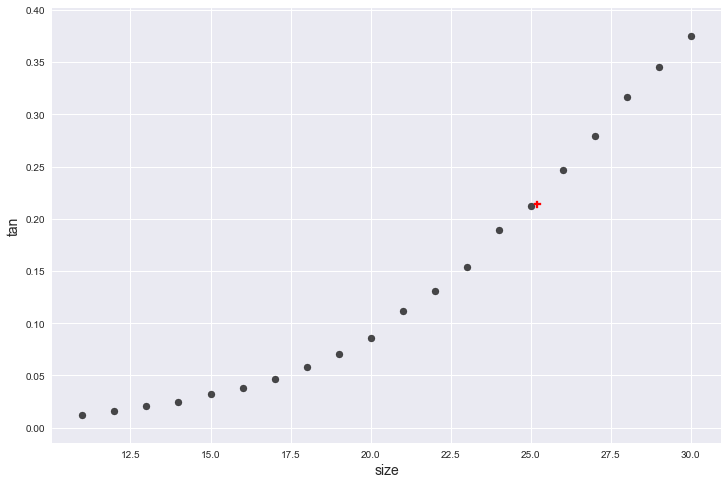

In [32]:
fig, ax = pl.subplots(figsize=(12,8))

scatter(sub[changed_param], sub[predict_value],c="black",alpha=0.7)
scatter(param, p, marker='P',c="red")
ylabel(predict_value,fontsize=14)
xlabel(changed_param,fontsize=14)

show()

## Example heatmap plotting

In [101]:
sizes = []
points = []
fs = []
fqs = []
for s in range(10,40):
    for f in range(5,50,2):
        for x in range(50, 120, 10):
            p = model.predict([[f, x, s, 6000, 1]])
            fs.append(f)
            points.append(p[0])
            sizes.append(s)
            fqs.append(x)
        
df = pd.DataFrame({'field': fs,'size':sizes,'frequency':fqs, 'tau': points})

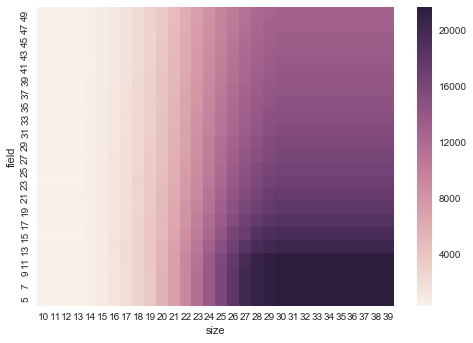

In [102]:
ax = sns.heatmap(df[(df['frequency'] == 110)].pivot("field", "size", "tau"))
ax.invert_yaxis()

show()